Script for making final plots

In [ ]:
!pip install rioxarray
!pip install geopandas
!pip install cartopy
!pip install xhistogram
!pip install xarrayMannKendall

In [ ]:
#Import packages
import xarray as xr
import rioxarray
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram

In [ ]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read in ERA5 data:
data1=xr.open_dataset('/dir/data.nc')
#data1= data1.sel(slice)
data1.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
data1.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (longitude: 261, latitude: 121, time: 996)
Coordinates:
  * longitude    (longitude) float32 -130.0 -129.8 -129.5 ... -65.5 -65.25 -65.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * time         (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
    spatial_ref  int64 0
Data variables:
    t2m          (time, latitude, longitude) float32 ...
    mer          (time, latitude, longitude) float32 ...
    mper         (time, latitude, longitude) float32 ...
    mslhf        (time, latitude, longitude) float32 ...
    msnlwrf      (time, latitude, longitude) float32 ...
    msnswrf      (time, latitude, longitude) float32 ...
    msshf        (time, latitude, longitude) float32 ...
    tp           (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    swvl2        (time, latitude, longitude) float32 ...
    swvl3        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-02 18:29:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
#isolate summers
def is_summer(month):
    return (month >= 6) & (month <= 8)

In [ ]:
data = data1.sel(time=is_summer(data1['time.month']))

In [ ]:
#import shapefile of US
shape1 = gpd.read_file('/dir/US_shapefile/cb_2018_us_nation_5m.shp', crs="epsg:4326")

In [ ]:
#root zone sm calculation
sm = data.swvl1*0.07+data.swvl2*0.21+data.swvl3*0.72
sm=sm.rename('rtsm')

In [ ]:
#calculate coupling metric
#Lv = (2.5*(10**6))-((2.386*10**3)*(data.t2m-273))
Lv = 1.9184*(10**6)*((data.t2m/(data.t2m-33.91))**2)#
Rn=data.msnswrf+data.msnlwrf
h = Rn - (Lv * (-data.mer))
hp = Rn - (Lv * (-data.mper))
ha = h.groupby("time.month") - h.groupby("time.month").mean("time")
han = ha.groupby("time.month")/ha.groupby("time.month").std("time")
hpa = hp.groupby("time.month") - hp.groupby("time.month").mean("time")
hpan = hpa.groupby("time.month")/hpa.groupby("time.month").std("time")
ta = data.t2m.groupby("time.month")-data.t2m.groupby("time.month").mean("time")
tan = ta.groupby("time.month")/ta.groupby("time.month").std("time")
e=han-hpan
e=e.rename('eb')
#Calculate coupling metric
Cp=e*tan

In [ ]:
#clip dataset using shapefile
Ps=data.tp.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)
Ts=data.t2m.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)
SMs=sm.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)
CPs=Cp.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)

In [ ]:
#clip and average over region
P=data.tp.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude'])
T=data.t2m.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude'])
SM=sm.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude'])
H=(h.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude']))
Hp=(hp.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False).mean(dim=['longitude','latitude']))

In [ ]:
#Calculate anomalies - of timeseries
P_anom = P.groupby("time.month") - P.groupby("time.month").mean("time")
P_anom_std = P_anom.groupby("time.month")/P_anom.groupby("time.month").std("time")

SM_anom = SM.groupby("time.month") - SM.groupby("time.month").mean("time")
SM_anom_std = SM_anom.groupby("time.month")/SM_anom.groupby("time.month").std("time")

T_anom = T.groupby("time.month") - T.groupby("time.month").mean("time")
T_anom_std = T_anom.groupby("time.month")/T_anom.groupby("time.month").std("time")

H_anom = H.groupby("time.month") - H.groupby("time.month").mean("time")
H_anom_std = H_anom.groupby("time.month")/H_anom.groupby("time.month").std("time")
Hp_anom = Hp.groupby("time.month") - Hp.groupby("time.month").mean("time")
Hp_anom_std = Hp_anom.groupby("time.month")/Hp_anom.groupby("time.month").std("time")

In [ ]:
E=H_anom_std-Hp_anom_std
SMT=(E.groupby('time.year').mean())*(T_anom_std.groupby('time.year').mean())

Text(1955, 5.5, 'Coupling')

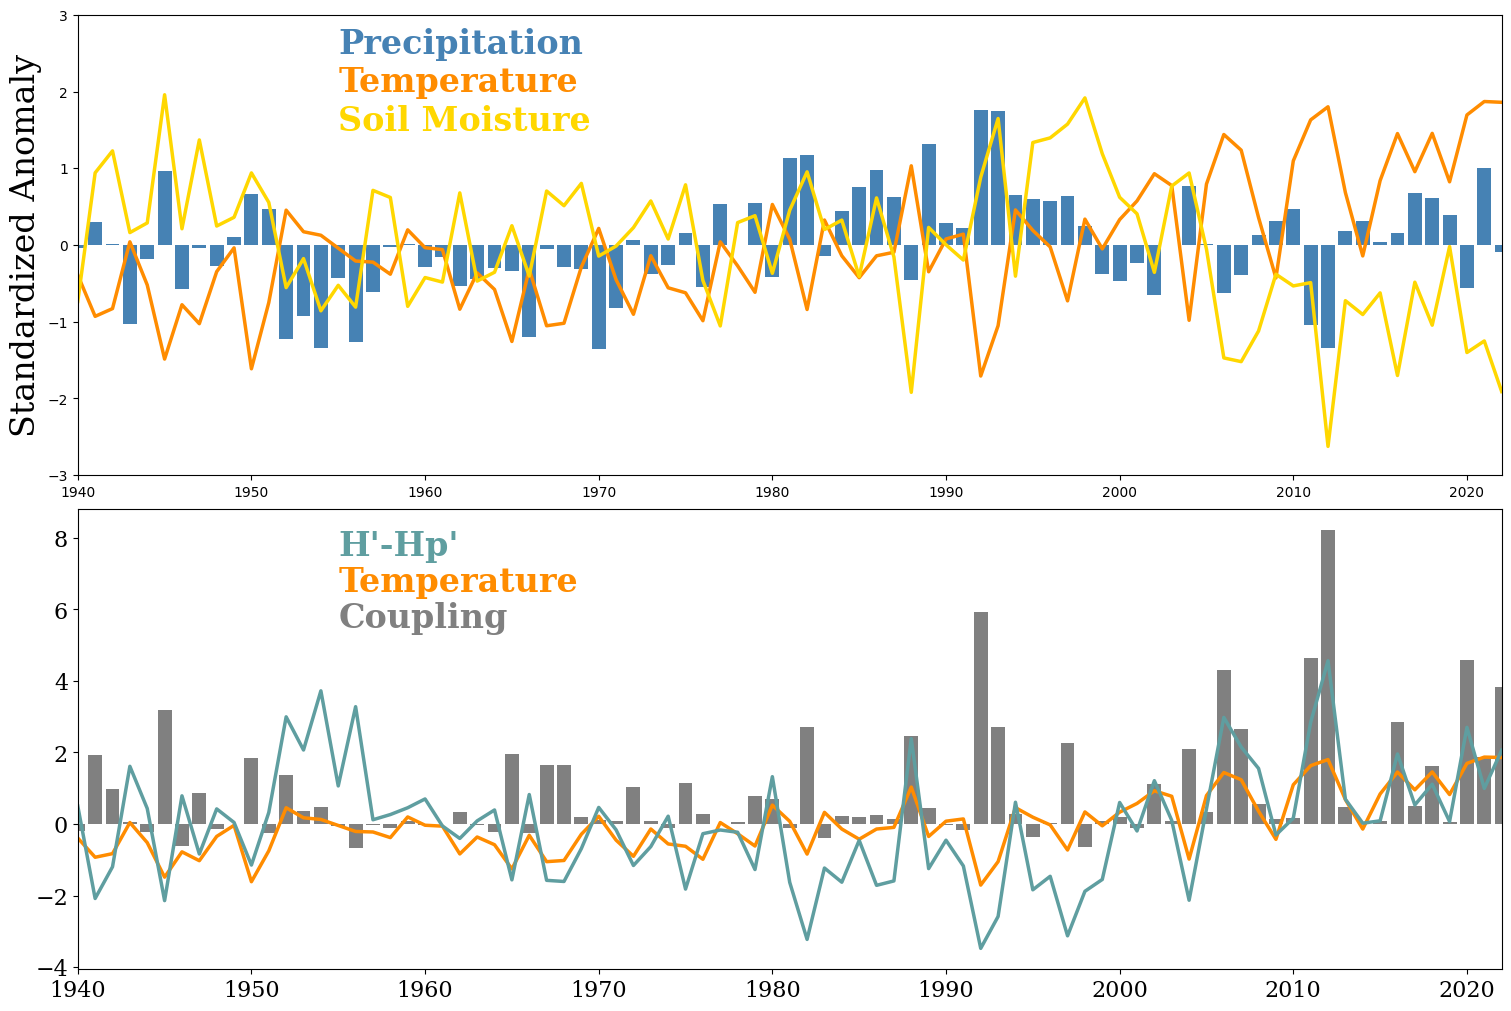

In [ ]:
#Plot whole summer-averaged time series
fig = plt.figure(figsize=(15,10),constrained_layout = True)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(np.arange(1940,2023),T_anom_std.groupby('time.year').mean(), linewidth=2.5,color='darkorange',label='Temperature')
ax1.plot(np.arange(1940,2023),SM_anom_std.groupby('time.year').mean(), linewidth=2.5,color='gold',label='Soil Moisture')
ax1.bar(np.arange(1940,2023),P_anom_std.groupby('time.year').mean(), linewidth=2.5,color='steelblue',label='Precipitation')
#plt.plot(np.arange(1940,2023),E_anom_std.groupby('time.year').mean(),color='Purple',label='Coupling')
#plt.bar(P_anom_std.time,P_anom_std)
#ax1.set_xlabel('Years')
ax1.set_ylabel('Standardized Anomaly',fontsize=24,fontname='Serif')

ax1.text(1955, 2.5, r'Precipitation',color='steelblue',fontsize=24,weight='bold',fontname='Serif')
ax1.text(1955, 2.0, r'Temperature',color='darkorange',fontsize=24,weight='bold',fontname='Serif')
ax1.text(1955, 1.5, r'Soil Moisture',color='gold',fontsize=24,weight='bold',fontname='Serif')
plt.xticks(fontsize=16,fontname='Serif')
plt.yticks(fontsize=16,fontname='Serif')
ax1.set_xlim([1940,2022])
ax1.set_ylim([-3,3])

ax2.plot(np.arange(1940,2023),T_anom_std.groupby('time.year').mean(), linewidth=2.5,color='darkorange',label='Temperature')
ax2.plot(np.arange(1940,2023),E.groupby('time.year').mean(), linewidth=2.5,color='cadetblue',label='Energy')
ax2.bar(np.arange(1940,2023),SMT, linewidth=2.5,color='grey',label='Coupling')
ax2.set_xlim([1940,2022])
ax2.text(1955, 7.5, r"H'-Hp'",color='cadetblue',fontsize=24,weight='bold',fontname='Serif')
ax2.text(1955, 6.5, r'Temperature',color='darkorange',fontsize=24,weight='bold',fontname='Serif')
ax2.text(1955, 5.5, r'Coupling',color='grey',fontsize=24,weight='bold',fontname='Serif')

In [ ]:
#calculate anomalies - spatially averaged values
Pa = Ps.groupby("time.month") - Ps.groupby("time.month").mean("time")
Pas = Pa.groupby("time.month")/Pa.groupby("time.month").std("time")

SMa = SMs.groupby("time.month") - SMs.groupby("time.month").mean("time")
SMas = SMa.groupby("time.month")/SMa.groupby("time.month").std("time")

Ta = Ts.groupby("time.month") - Ts.groupby("time.month").mean("time")
Tas = Ta.groupby("time.month")/Ta.groupby("time.month").std("time")

In [ ]:
from math import nan
mask= Ts[1,:,:].where(Ts[1,:,:] != nan, other=1)
tot_area=31*31*(mask.count(dim=['longitude','latitude']))

In [ ]:
#threshmin=-1; threshmax=-2
scdh1 = 31*31*SMas.where((SMas<-1) & (Tas>1)).count(dim=['longitude','latitude'])
scdh= 100*(scdh1.groupby('time.year').sum())/(3*tot_area)
pcdh1 = 31*31*Pas.where((Pas<-1) & (Tas>1)).count(dim=['longitude','latitude'])
pcdh= 100*(pcdh1.groupby('time.year').sum())/(3*tot_area)
#plt.plot(scdh)
#plt.plot(pcdh)

In [ ]:
scdh2 = 100*(SMas.where((SMas<-1) & (Tas>1)).count(dim='time'))/len(SMas[:,1,1])
pcdh2 = 100*(Pas.where((Pas<-1) & (Tas>1)).count(dim='time'))/len(Pas[:,1,1])
scdh2.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
scdh2.rio.write_crs("epsg:4326", inplace=True)
scdhs=scdh2.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)
pcdh2.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
pcdh2.rio.write_crs("epsg:4326", inplace=True)
pcdhs=pcdh2.rio.clip(shape1.geometry.apply(mapping), shape1.crs, drop=False)
#scdhs.plot()

Text(0, 0.5, 'Area Exposed (%)')

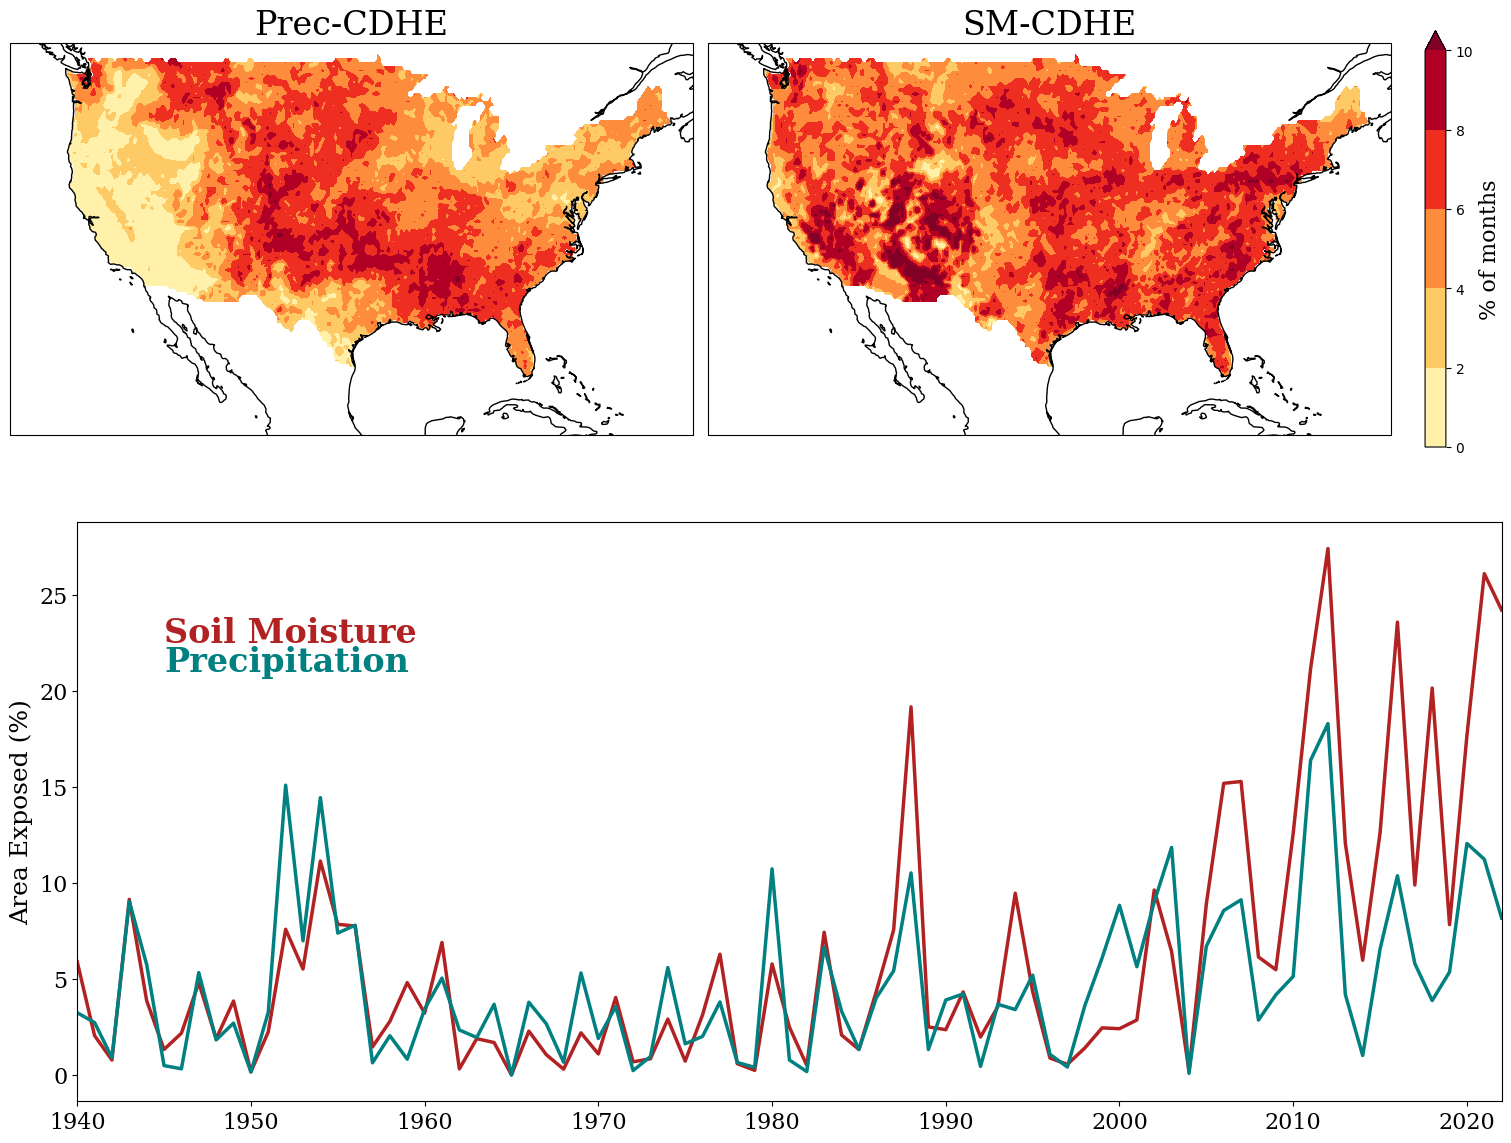

In [ ]:
levels=np.arange(0,12,2)
fig = plt.figure(figsize=(15,12),constrained_layout = True)
ax1 = fig.add_subplot(2,2,1,projection=ccrs.Mercator(central_longitude=-98))
ax2 = fig.add_subplot(2,2,2,projection=ccrs.Mercator(central_longitude=-98))
ax3 = fig.add_subplot(2,1,2)
cf1=ax1.contourf(pcdhs.longitude, pcdhs.latitude, pcdhs, cmap='YlOrRd',levels=levels, extend='max',transform=ccrs.PlateCarree());
ax1.coastlines()
ax1.set_title('Prec-CDHE',fontsize=24,fontname='Serif')
#ax1.set_ylabel('Latitude',fontsize=24,fontname='Serif')
ax1.set_xticks([], crs=ccrs.PlateCarree())
cf2=ax2.contourf(scdhs.longitude, scdhs.latitude, scdhs, cmap='YlOrRd',levels=levels, extend='max',transform=ccrs.PlateCarree());
ax2.coastlines()
ax2.set_title('SM-CDHE',fontsize=24,fontname='Serif')
#cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(cf2, ax=ax2,shrink=0.7)
cbar.set_label(label='% of months',fontsize=16,fontname='Serif')
ax3.plot(np.arange(1940,2023),scdh,color='firebrick', linewidth=2.5)
ax3.plot(np.arange(1940,2023),pcdh,color='teal', linewidth=2.5)
ax3.set_xlim([1940,2022])
plt.xticks(fontsize=16,fontname='Serif')
plt.yticks(fontsize=16,fontname='Serif')
ax3.text(1945, 22.5, r'Soil Moisture',color='firebrick',fontsize=24,weight='bold',fontname='Serif')
ax3.text(1945, 21, r'Precipitation',color='teal',fontsize=24,weight='bold',fontname='Serif')
ax3.set_ylabel('Area Exposed (%)',fontsize=18,fontname='Serif')

#plt.savefig('/content/drive/MyDrive/ClimateDynamicsTermProj/Plots/plot1.tif')

Text(0, 0.5, 'No. of CDHEs')

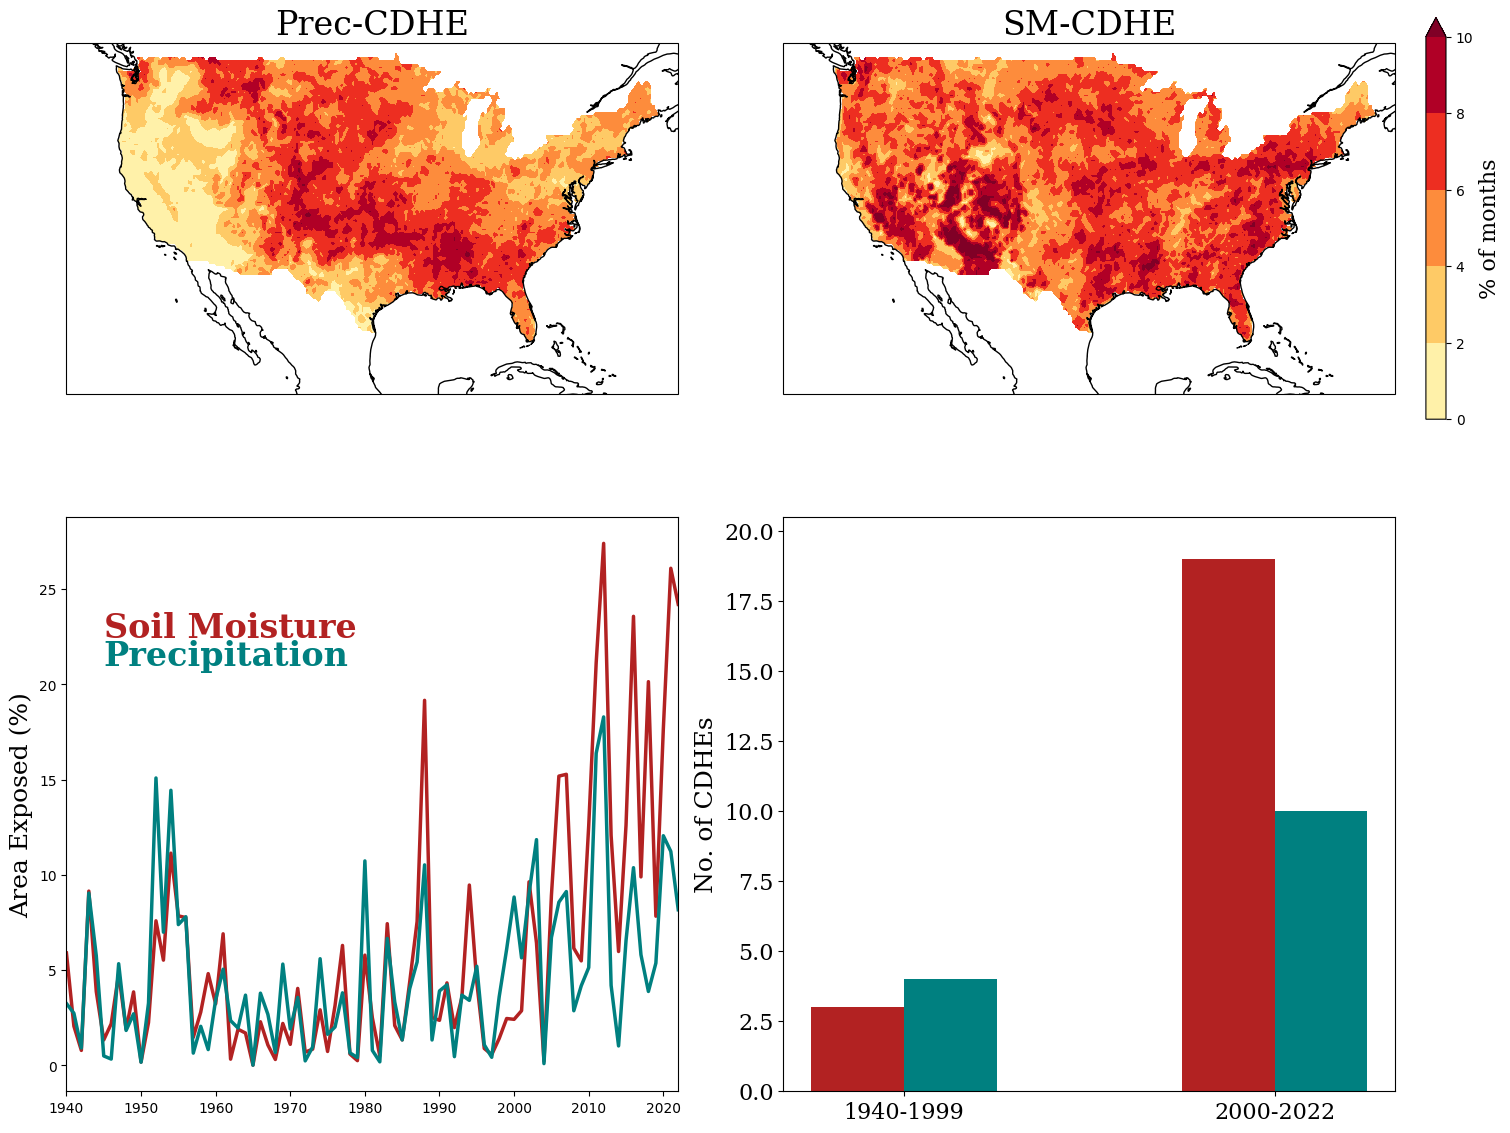

In [ ]:
levels=np.arange(0,12,2)
fig = plt.figure(figsize=(15,12),constrained_layout = True)
ax1 = fig.add_subplot(2,2,1,projection=ccrs.Mercator(central_longitude=-98))
ax2 = fig.add_subplot(2,2,2,projection=ccrs.Mercator(central_longitude=-98))
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
cf1=ax1.contourf(pcdhs.longitude, pcdhs.latitude, pcdhs, cmap='YlOrRd',levels=levels, extend='max',transform=ccrs.PlateCarree());
ax1.coastlines()
ax1.set_title('Prec-CDHE',fontsize=24,fontname='Serif')
#ax1.set_ylabel('Latitude',fontsize=24,fontname='Serif')
ax1.set_xticks([], crs=ccrs.PlateCarree())

cf2=ax2.contourf(scdhs.longitude, scdhs.latitude, scdhs, cmap='YlOrRd',levels=levels, extend='max',transform=ccrs.PlateCarree());
ax2.coastlines()
ax2.set_title('SM-CDHE',fontsize=24,fontname='Serif')
#cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(cf2, ax=ax2,shrink=0.7)
cbar.set_label(label='% of months',fontsize=16,fontname='Serif')

ax3.plot(np.arange(1940,2023),scdh,color='firebrick', linewidth=2.5)
ax3.plot(np.arange(1940,2023),pcdh,color='teal', linewidth=2.5)
ax3.set_xlim([1940,2022])
#ax3.set_xticks(np.arange(1940,2023))
#ax3.set_yticks(np.arange(0,30))
plt.xticks(fontsize=16,fontname='Serif')
plt.yticks(fontsize=16,fontname='Serif')
ax3.text(1945, 22.5, r'Soil Moisture',color='firebrick',fontsize=24,weight='bold',fontname='Serif')
ax3.text(1945, 21, r'Precipitation',color='teal',fontsize=24,weight='bold',fontname='Serif')
ax3.set_ylabel('Area Exposed (%)',fontsize=18,fontname='Serif')

per1 = ['1940-1999','2000-2022']
X_axis = np.arange(len(per1))
sCE = [3,19];
pCE = [4,10];
barWidth=0.25
ax4.bar(X_axis - 0.125,sCE,color='firebrick',width = barWidth)
ax4.bar(X_axis + 0.125,pCE,color='teal',width = barWidth)
#ax4.set_xticks(X_axis)
plt.xticks(X_axis, per1,fontsize=16,fontname='Serif')
ax4.set_ylim([0,20.5])
ax4.set_ylabel('No. of CDHEs',fontsize=18,fontname='Serif')
#plt.savefig('/content/drive/MyDrive/ClimateDynamicsTermProj/Plots/plot1.tif')

In [ ]:
threshmin=-1; threshmax=1; threshmed=0
pSPI_comp = Pas.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax)).mean(dim='time')
pSSI_comp = SMas.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax)).mean(dim='time')
pSTI_comp = Tas.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax)).mean(dim='time')
pCP_comp = CPs.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax)).mean(dim='time')
sSPI_comp = Pas.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax)).mean(dim='time')
sSSI_comp = SMas.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax)).mean(dim='time')
sSTI_comp = Tas.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax)).mean(dim='time')
sCP_comp = CPs.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax)).mean(dim='time')

# pSPI_comp = Pas.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax) & (SM_anom_std>=threshmed)).mean(dim='time')
# pSSI_comp = SMas.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax) & (SM_anom_std>=threshmed)).mean(dim='time')
# pSTI_comp = Tas.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax) & (SM_anom_std>=threshmed)).mean(dim='time')
# pCP_comp = CPs.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax) & (SM_anom_std>=threshmed)).mean(dim='time')
# sSPI_comp = Pas.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax) & (P_anom_std>=threshmed)).mean(dim='time')
# sSSI_comp = SMas.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax) & (P_anom_std>=threshmed)).mean(dim='time')
# sSTI_comp = Tas.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax) & (P_anom_std>=threshmed)).mean(dim='time')
# sCP_comp = CPs.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax) & (P_anom_std>=threshmed)).mean(dim='time')

In [ ]:
pcount=Pas.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax)).dropna('time', how='all').time
scount=SMas.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax)).dropna('time', how='all').time
#pcount=Pas.where((P_anom_std<=threshmin) & (T_anom_std>=threshmax) & (SM_anom_std>=threshmed)).dropna('time', how='all').time
#scount=SMas.where((SM_anom_std<=threshmin) & (T_anom_std>=threshmax) & (P_anom_std>=threshmed)).dropna('time', how='all').time

In [ ]:
pcount,scount

(<xarray.DataArray 'time' (time: 14)>
 array(['1952-06-01T00:00:00.000000000', '1954-07-01T00:00:00.000000000',
        '1980-07-01T00:00:00.000000000', '1988-06-01T00:00:00.000000000',
        '2000-08-01T00:00:00.000000000', '2006-06-01T00:00:00.000000000',
        '2006-07-01T00:00:00.000000000', '2011-07-01T00:00:00.000000000',
        '2011-08-01T00:00:00.000000000', '2012-06-01T00:00:00.000000000',
        '2012-07-01T00:00:00.000000000', '2012-08-01T00:00:00.000000000',
        '2016-06-01T00:00:00.000000000', '2022-06-01T00:00:00.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
   * time         (time) datetime64[ns] 1952-06-01 1954-07-01 ... 2022-06-01
     spatial_ref  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     month        (time) int64 6 7 7 6 8 6 7 7 8 6 7 8 6 6
 Attributes:
     long_name:  time,
 <xarray.DataArray 'time' (time: 22)>
 array(['1954-07-01T00:00:00.000000000', '1988-06-01T00:00:00.000000000',
        '1994-06-01T00:00:00.000000000', '2006-06-01T00

Text(0.5, 1.0, 'SM-T Coupling')

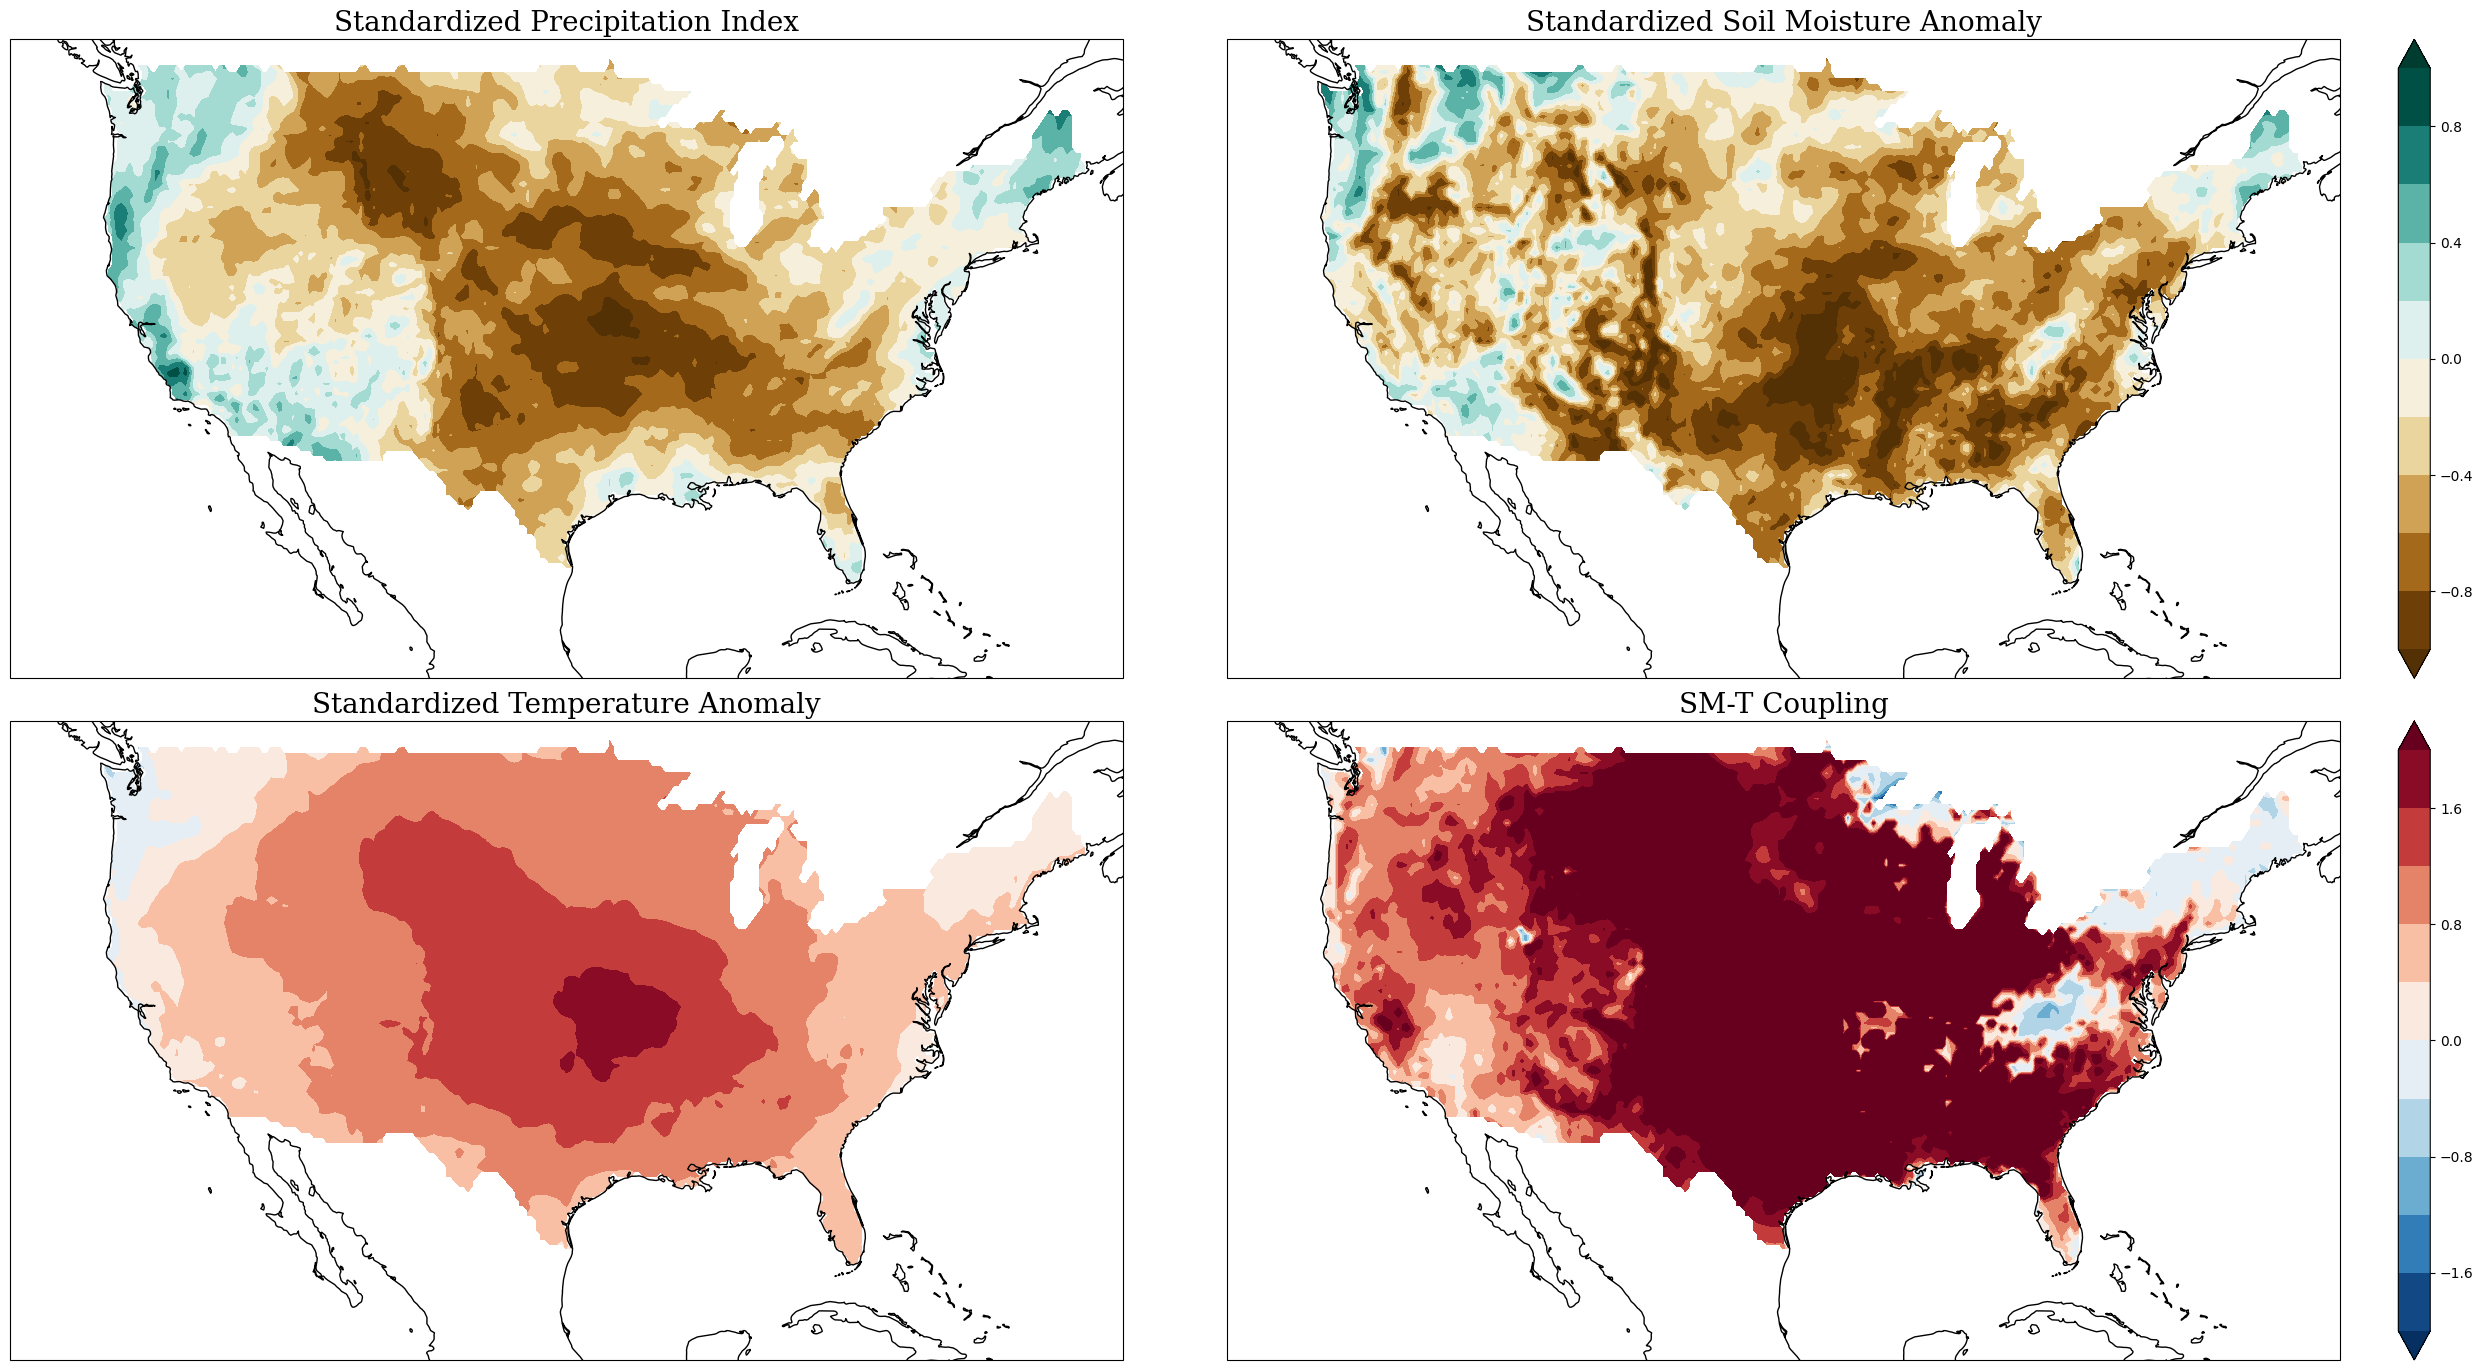

In [ ]:
## CDHEs using Precipitation
levels=np.arange(-1,1.2,0.2)
fig = plt.figure(figsize=(25, 20),constrained_layout = True)
ax = fig.add_subplot(3,2,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(pSPI_comp.longitude, pSPI_comp.latitude, pSPI_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
#cb = plt.colorbar(cf1,orientation='horizontal')
#cb.set_label('Standardized Precipitation Index',fontsize=14,fontname='Serif')
ax.set_title('Standardized Precipitation Index',fontsize=20,fontname='Serif')
ax = fig.add_subplot(3,2,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(pSSI_comp.longitude, pSSI_comp.latitude, pSSI_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1,ax=ax)#orientation='horizontal')
#cb.set_label('Standardized Soil Moisture Anomaly',fontsize=14,fontname='Serif')
ax.set_title('Standardized Soil Moisture Anomaly',fontsize=20,fontname='Serif')
levels=np.arange(-2,2.4,0.4)
ax2 = fig.add_subplot(3,2,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(pSTI_comp.longitude, pSTI_comp.latitude, pSTI_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
#cb = plt.colorbar(cf2,orientation='horizontal')
#cb.set_label('Standardized Temperature Anomaly',fontsize=14,fontname='Serif')
ax2.set_title('Standardized Temperature Anomaly',fontsize=20,fontname='Serif')
ax2 = fig.add_subplot(3,2,4,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(pCP_comp.longitude, pCP_comp.latitude, pCP_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2,ax=ax2)#,orientation='horizontal')
#cb.set_label('SM-T Coupling',fontsize=14,fontname='Serif')
ax2.set_title('SM-T Coupling',fontsize=20,fontname='Serif')

Text(0.5, 1.0, 'SM-T Coupling')

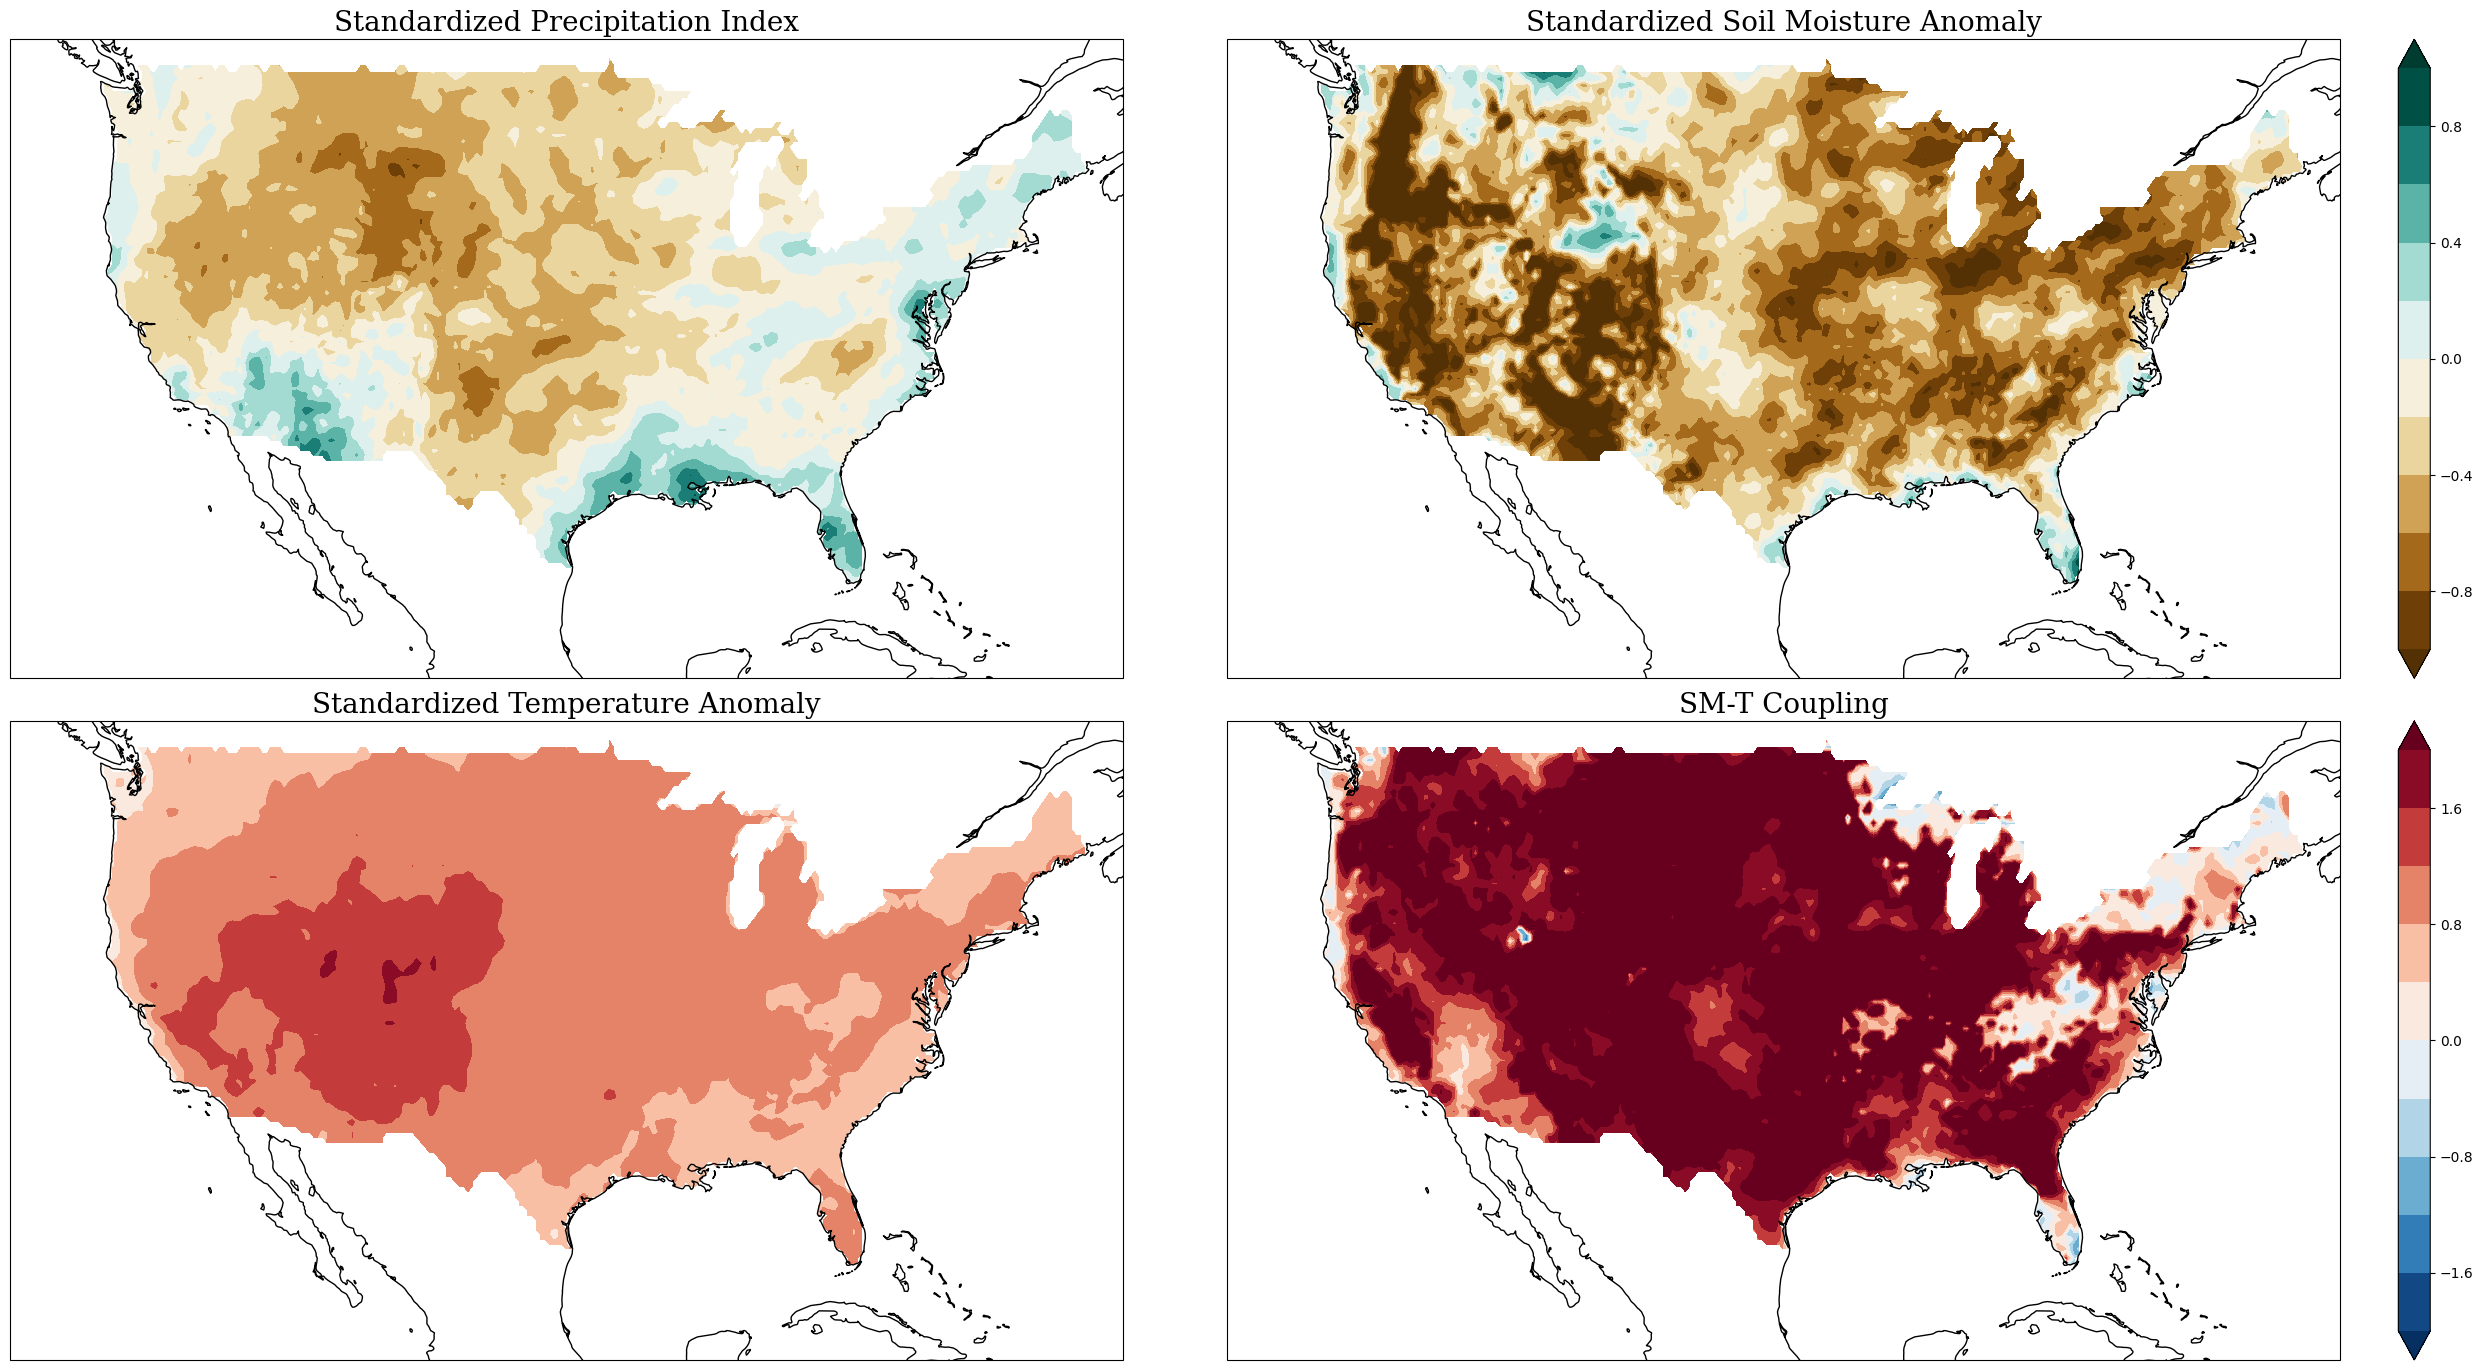

In [ ]:
## CDHEs using Soil Moisture
levels=np.arange(-1,1.2,0.2)
fig = plt.figure(figsize=(25, 20),constrained_layout = True)
ax = fig.add_subplot(3,2,1,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(sSPI_comp.longitude, sSPI_comp.latitude, sSPI_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
#cb = plt.colorbar(cf1,orientation='horizontal')
#cb.set_label('Standardized Precipitation Index',fontsize=14,fontname='Serif')
ax.set_title('Standardized Precipitation Index',fontsize=20,fontname='Serif')
ax = fig.add_subplot(3,2,2,projection=ccrs.Mercator(central_longitude=-98))
ax.coastlines()
cf1 = ax.contourf(sSSI_comp.longitude, sSSI_comp.latitude, sSSI_comp, cmap='BrBG',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf1,ax=ax)#orientation='horizontal')
#cb.set_label('Standardized Soil Moisture Anomaly',fontsize=14,fontname='Serif')
ax.set_title('Standardized Soil Moisture Anomaly',fontsize=20,fontname='Serif')
levels=np.arange(-2,2.4,0.4)
ax2 = fig.add_subplot(3,2,3,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(sSTI_comp.longitude, sSTI_comp.latitude, sSTI_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
#cb = plt.colorbar(cf2,orientation='horizontal')
#cb.set_label('Standardized Temperature Anomaly',fontsize=14,fontname='Serif')
ax2.set_title('Standardized Temperature Anomaly',fontsize=20,fontname='Serif')
ax2 = fig.add_subplot(3,2,4,projection=ccrs.Mercator(central_longitude=-98))
ax2.coastlines()
cf2 = ax2.contourf(sCP_comp.longitude, sCP_comp.latitude, sCP_comp, cmap='RdBu_r',levels=levels, extend='both',
                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf2,ax=ax2)#,orientation='horizontal')
#cb.set_label('SM-T Coupling',fontsize=14,fontname='Serif')
ax2.set_title('SM-T Coupling',fontsize=20,fontname='Serif')